In [25]:
# INSTALLS
%pip install opencv-python
%pip install torch torchvision torchaudio
%pip install tensorflow-cpu
%pip install albumentations
%pip install grad-cam
%pip install numpy pandas matplotlib seaborn scikit-learn Pillow tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [26]:
# IMPORTS
# System & Utilities
import os
import random
from tqdm import tqdm
import shutil

# Data handling
import numpy as np
import pandas as pd
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Frameworks (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

# TensorFlow (Optional - For GAN or alternative frameworks)
# import tensorflow as tf
# from tensorflow import keras

# Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics & Utils
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Explainability
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

# import albumentations as A
# from albumentations.pytorch import ToTensorV2

In [35]:
# Define transformations using Albumentations
def get_transforms(phase):
    if phase == 'train':
        return A.Compose([
            A.Resize(128, 128),
            A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(128, 128),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2(),
        ])

In [37]:
class KneeOADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in range(5):
            label_folder = os.path.join(root_dir, str(label))
            if not os.path.exists(label_folder): continue
            for img_file in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_file)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to 3-channel
        image = image / 255.0  # Normalize to [0, 1]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

In [39]:
train_dataset = KneeOADataset(root_dir='dataset/train', transform=get_transforms('train'))
val_dataset = KneeOADataset(root_dir='dataset/val', transform=get_transforms('val'))
test_dataset = KneeOADataset(root_dir='dataset/test', transform=get_transforms('val'))
auto_test_dataset = KneeOADataset(root_dir='dataset/auto_test', transform=get_transforms('val'))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
auto_test_loader = DataLoader(auto_test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [41]:
def get_model(pretrained=True, num_classes=5):
    model = models.resnet18(pretrained=pretrained)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [45]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

        # Save model after each epoch
        torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

In [47]:
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

Epoch 1/10: 100%|██████████| 181/181 [06:35<00:00,  2.18s/it]


Epoch [1/10], Train Loss: 1.4225, Train Acc: 38.01%, Val Loss: 1.9320, Val Acc: 12.83%


Epoch 2/10: 100%|██████████| 181/181 [06:21<00:00,  2.11s/it]


Epoch [2/10], Train Loss: 1.3851, Train Acc: 39.51%, Val Loss: 1.6042, Val Acc: 33.78%


Epoch 3/10: 100%|██████████| 181/181 [06:12<00:00,  2.06s/it]


Epoch [3/10], Train Loss: 1.3276, Train Acc: 42.16%, Val Loss: 1.7377, Val Acc: 39.71%


Epoch 4/10: 100%|██████████| 181/181 [06:11<00:00,  2.05s/it]


Epoch [4/10], Train Loss: 1.2796, Train Acc: 44.01%, Val Loss: 18.0624, Val Acc: 3.27%


Epoch 5/10: 100%|██████████| 181/181 [06:05<00:00,  2.02s/it]


Epoch [5/10], Train Loss: 1.2533, Train Acc: 45.38%, Val Loss: 1.8099, Val Acc: 39.71%


Epoch 6/10: 100%|██████████| 181/181 [06:11<00:00,  2.05s/it]


Epoch [6/10], Train Loss: 1.2264, Train Acc: 46.40%, Val Loss: 1.5273, Val Acc: 18.64%


Epoch 7/10: 100%|██████████| 181/181 [06:15<00:00,  2.07s/it]


Epoch [7/10], Train Loss: 1.2157, Train Acc: 47.27%, Val Loss: 1.6712, Val Acc: 25.79%


Epoch 8/10: 100%|██████████| 181/181 [06:39<00:00,  2.21s/it]


Epoch [8/10], Train Loss: 1.1958, Train Acc: 47.98%, Val Loss: 1.6714, Val Acc: 13.92%


Epoch 9/10: 100%|██████████| 181/181 [06:36<00:00,  2.19s/it]


Epoch [9/10], Train Loss: 1.1737, Train Acc: 48.60%, Val Loss: 13.9597, Val Acc: 3.27%


Epoch 10/10: 100%|██████████| 181/181 [05:20<00:00,  1.77s/it]


Epoch [10/10], Train Loss: 1.1588, Train Acc: 49.91%, Val Loss: 1.6967, Val Acc: 39.71%


In [53]:
def evaluate_model(model, data_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Classification Report:

              precision    recall  f1-score   support

           0     0.3868    1.0000    0.5578       639
           1     0.0000    0.0000    0.0000       296
           2     0.7500    0.0067    0.0133       447
           3     0.0000    0.0000    0.0000       223
           4     0.0000    0.0000    0.0000        51

    accuracy                         0.3877      1656
   macro avg     0.2274    0.2013    0.1142      1656
weighted avg     0.3517    0.3877    0.2188      1656



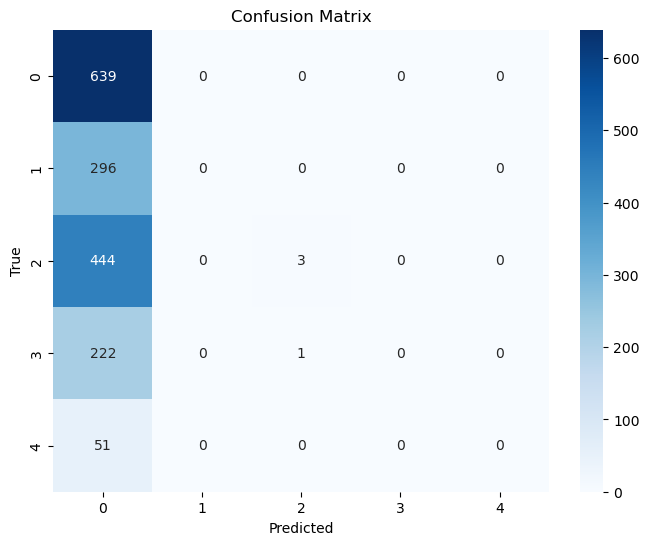

In [55]:
evaluate_model(model, test_loader, device)

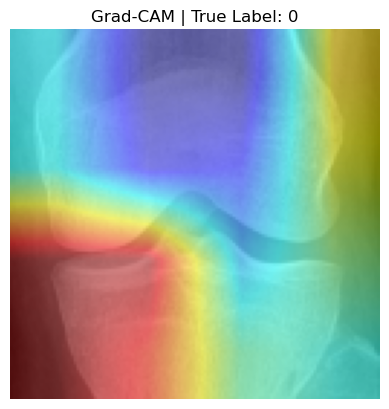

In [61]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Get test sample
images, labels = next(iter(test_loader))
image_tensor = images[0].unsqueeze(0).to(device)
label = labels[0].item()

# Generate Grad-CAM
grayscale_cam = cam(input_tensor=image_tensor, targets=[ClassifierOutputTarget(label)])[0]
image_np = image_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Grad-CAM | True Label: {label}")
plt.axis('off')
plt.show()

cam.__del__()  # Clean-up

In [63]:
# Generator for cGAN
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=5, img_shape=(1, 128, 128)):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, latent_dim)

        self.init_size = img_shape[1] // 4  # 128 → 32
        self.fc = nn.Sequential(nn.Linear(latent_dim * 2, 128 * self.init_size ** 2))

        self.model = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 32 → 64
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),  # 64 → 128
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        x = torch.cat((noise, label_input), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, self.init_size, self.init_size)
        img = self.model(x)
        return img

In [79]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=5, img_shape=(1, 128, 128)):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, np.prod(img_shape))

        self.model = nn.Sequential(
            nn.Conv2d(2, 64, 3, stride=2, padding=1),  # [B, 2, 128, 128] → [B, 64, 64, 64]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # → [B, 128, 32, 32]
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        )

        # Dynamically calculate flattened size
        ds_size = img_shape[1] // 4  # 128 → 32
        self.adv_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels).view(img.size(0), 1, 128, 128)
        d_in = torch.cat((img, label_input), dim=1)  # Channel-wise concat
        features = self.model(d_in)
        validity = self.adv_layer(features)
        return validity

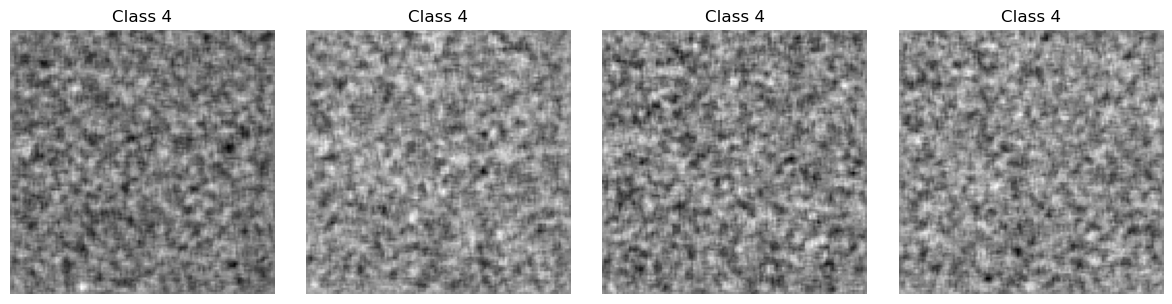

In [81]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the generator (reuse this if already defined)
generator = Generator(latent_dim=100).to(device)
generator.eval()  # Set to eval mode

# Load pretrained weights if you have them (skip this for now)
# generator.load_state_dict(torch.load("generator_epoch_X.pth"))

# Generate noise and labels
n_samples = 4
latent_dim = 100
z = torch.randn(n_samples, latent_dim).to(device)
labels = torch.full((n_samples,), 4, dtype=torch.long).to(device)  # Class 4

# Generate images
with torch.no_grad():
    gen_imgs = generator(z, labels).cpu()

# Plot results
fig, axs = plt.subplots(1, n_samples, figsize=(12, 3))
for i in range(n_samples):
    axs[i].imshow(gen_imgs[i].squeeze(), cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Class 4")

plt.tight_layout()
plt.show()

In [83]:
class OAGANDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in range(5):  # 0 to 4
            class_folder = os.path.join(root_dir, str(label))
            for fname in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, fname))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128, 128))
        image = image.astype(np.float32) / 127.5 - 1.0  # Normalize to [-1, 1]
        image = torch.tensor(image).unsqueeze(0)  # Add channel dim
        return image, label

In [85]:
gan_dataset = OAGANDataset(root_dir='dataset/train')
gan_loader = DataLoader(gan_dataset, batch_size=64, shuffle=True, num_workers=0)

In [87]:
adversarial_loss = nn.BCELoss()

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [89]:
n_epochs = 50
batch_size = 64
latent_dim = 100
sample_interval = 10  # Save grid every X epochs

[Epoch 1/50] [Batch 0/91] [D loss: 0.5657] [G loss: 1.9526]


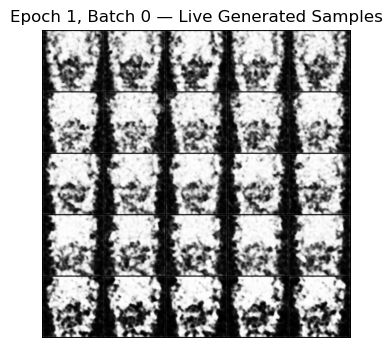

In [ ]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

n_epochs = 50
latent_dim = 100
sample_interval = 10
os.makedirs("gan_outputs", exist_ok=True)

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(gan_loader):
        batch_size = imgs.size(0)
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, 5, (batch_size,), dtype=torch.long).to(device)
        gen_imgs = generator(z, gen_labels)
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, real)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        real_validity = discriminator(real_imgs, labels)
        fake_validity = discriminator(gen_imgs.detach(), gen_labels)
        real_loss = adversarial_loss(real_validity, real)
        fake_loss = adversarial_loss(fake_validity, fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Print progress every 50 batches
        if i % 50 == 0:
            print(f"[Epoch {epoch+1}/{n_epochs}] [Batch {i}/{len(gan_loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        # Visualize live samples every 300 batches
        if i % 300 == 0:
            generator.eval()
            with torch.no_grad():
                z_sample = torch.randn(25, latent_dim).to(device)
                label_sample = torch.tensor([i for i in range(5) for _ in range(5)]).to(device)
                fake_imgs = generator(z_sample, label_sample)
                fake_imgs = (fake_imgs + 1) / 2  # Rescale to [0, 1]

                grid = vutils.make_grid(fake_imgs.cpu(), nrow=5, normalize=True)
                plt.figure(figsize=(10, 4))
                plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
                plt.title(f"Epoch {epoch+1}, Batch {i} — Live Generated Samples")
                plt.axis("off")
                plt.show()
            generator.train()

    # Save static grid at interval
    if (epoch + 1) % sample_interval == 0:
        generator.eval()
        with torch.no_grad():
            z = torch.randn(25, latent_dim).to(device)
            sample_labels = torch.tensor([i for i in range(5) for _ in range(5)]).to(device)
            gen_imgs = generator(z, sample_labels)
            gen_imgs = (gen_imgs + 1) / 2.0
            vutils.save_image(gen_imgs, f"gan_outputs/epoch_{epoch+1}.png", nrow=5, normalize=True)
        generator.train()